In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import time
import cvxpy as cp

%matplotlib inline

%run bandit_definitions.py
%run algorithms.py
%run sim_utilities.py
%run optim_utils.py

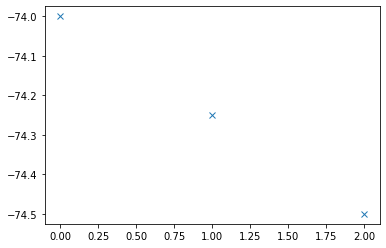

In [3]:
K = 3
T = 10000
np.random.seed(0)


ds = np.linspace(1, 1+0.01, 3)
M = 1
scale = 50
mus = M - scale*(1 / 2 + ds)
band = UnifDBand(K, mus, M, scale)

plt.plot(band.mus, 'x')

5.53819103927055e-05


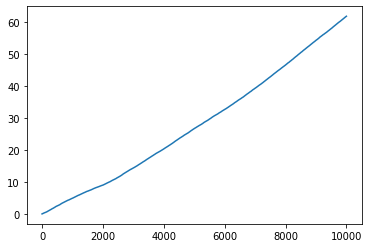

In [4]:
adahedgeexp3 = AdaHedgeExp3Bounded(K, M=M)

np.random.seed(0)

band.reset()
adahedgeexp3.reset()
for _ in range(T):
    adahedgeexp3.play_once(band)
    
print(adahedgeexp3.lr_value)
plt.plot(np.array(band.cum_regret) / scale)

0.0060514799530586175


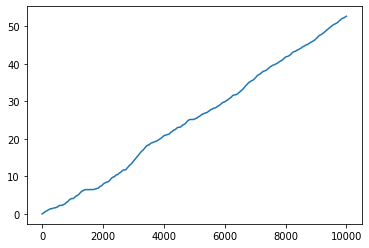

In [5]:
alg = Exp3(K , M=M, label="Vanilla Exp3")

np.random.seed(0)

band.reset()
alg.reset()
for _ in range(T):
    alg.play_once(band)
    
print(alg.lr_value)
plt.plot(np.array(band.cum_regret) / scale)

In [ ]:
np.random.seed(0)

Ntest = lambda _ : 30
K = 3
T = 10000

ds = np.linspace(1, 1+0.1, K)
M = 1
scales = [0.01, 1, 50]
mus_list = [M - scale*(1/2 + ds) for scale in scales]

band_list = [UnifDBand(K, mus_list[i], M, scale) for i, scale in enumerate(scales)]

alg_list = [
    UCB(K, sig=0.1, label="UCB \sigma = "+str(0.1)),
    UCB(K, sig=1, label="UCB \sigma = 1"),
    UCB(K, sig=scale, label="UCB \sigma = scale ="+str(scale)),
    UCB(K, sig=200, label="UCB \sigma = 200"),
    #Exp3(K , M=M, label="Vanilla Exp3"),
    AdaHedgeExp3(K, M=M, label="True AdaExp3"),
    AdaFTRLTsallis(K, M=M, sym=False, proxy=True, label="AdaFTRL Tsallis prox"), 
    AdaFTRLTsallis(K, M=M, sym=False, label="AdaFTRL Tsallis"), 
    #FTRL_w_reg(K, opt_ut.Tsallis_1_2_sym(K), M=M, label="SymTsallis"),
    #AdaFTRLTsallis(K, M=100, label="AdaHedge Tsallis M={}".format(100)),
    UCB(K, sig=0, label="FTL"),
    RandomPlay(K, label="random play"),
    ]

data_dict={
    'name':'Long Name',
    'short_name':'short_name',
    'T':T,
    'Ntest':Ntest,
    'band_list':band_list,
    'alg_list':alg_list,
    'results':None,
    'scales':scales,
    'seed':0
}

launch(data_dict, fair_reg=False)

Run number  0  /  30
Run number  5  /  30
Run number  10  /  30
Run number  15  /  30
Run number  20  /  30
Run number  25  /  30
UCB \sigma = 0.1  took  5.9171247482299805  total, i.e.  0.19723749160766602  per run
Run number  0  /  30
Run number  5  /  30
Run number  10  /  30
Run number  15  /  30
Run number  20  /  30
Run number  25  /  30
UCB \sigma = 1  took  6.058349132537842  total, i.e.  0.20194497108459472  per run
Run number  0  /  30
Run number  5  /  30
Run number  10  /  30
Run number  15  /  30
Run number  20  /  30
Run number  25  /  30
UCB \sigma = scale =50  took  5.403816223144531  total, i.e.  0.18012720743815105  per run
Run number  0  /  30
Run number  5  /  30
Run number  10  /  30
Run number  15  /  30
Run number  20  /  30
Run number  25  /  30
UCB \sigma = 200  took  6.740849018096924  total, i.e.  0.22469496726989746  per run
Run number  0  /  30
Run number  5  /  30
Run number  10  /  30
Run number  15  /  30
Run number  20  /  30
Run number  25  /  30
True 

In [ ]:
plot_and_save(data_dict, save_data=True, skip_algs=[8], log_scale=False, show_vars=False, rescale=True)

In [45]:
def plot_deltas(alg_list):
    for alg in alg_list:
        if 'mix_gaps' in vars(alg).keys():
            plt.plot([x for x in alg.mix_gaps], label=alg.label)
            plt.legend()
            plt.show()
        if 'true_mix_gaps' in vars(alg).keys():
            plt.plot([x for x in alg.true_mix_gaps], label=alg.label+" True Mix Gaps", alpha=0.3)
            plt.legend()
            plt.show()

def plot_etas(alg_list, normalize=False):
    for alg in alg_list:
        deltas = alg.mix_gaps
        etas = deltas_to_etas(deltas)
        if normalize:
            plt.plot( [1 / np.square(eta) for eta in etas])
            plt.title("1 / etas^2 : "+alg.label)
        else:
            plt.plot(etas)
            plt.title("etas : "+alg.label)
        plt.show()
        
def deltas_to_etas(deltas):
    r = []
    cum = 0
    for i, delta in enumerate(deltas):
        cum += delta
        if cum == 0:
            r.append(1000)
        else:
            r.append(1. / cum)
    return r

#plot_deltas(alg_list[2:])
#plot_etas(alg_list[2:], normalize=True)


In [ ]:
np.random.seed(50)
K = 15

l0 = 1
p = np.random.rand(K) 
p /= np.sum(p)
eta0 = 1

def objective(l, p, K, eta=1, i= 0):
    return eta*np.square(l)*np.power(p[i], -1/2)

ls = np.linspace(0, 5, 100)

print(p)
for i in range(K):
    print(p[i])
    
    true_mixs = [mix_gap_comp(l, p, K, eta=eta0, i=i)[1] for l in ls]
    bound = [objective(l, p, K, eta=eta0, i=i) for l in ls]
    plt.plot(ls, true_mixs , label="true")
    plt.plot(ls, bound, label="bound")
    plt.legend()
    plt.show()
    diff = np.array(bound) - np.array(true_mixs)
    plt.plot(ls,  diff)
    plt.show()
    print("minimum difference :", min(diff))

In [36]:
[c for c in plt.get_cmap('Dark2').colors]

[(0.10588235294117647, 0.6196078431372549, 0.4666666666666667),
 (0.8509803921568627, 0.37254901960784315, 0.00784313725490196),
 (0.4588235294117647, 0.4392156862745098, 0.7019607843137254),
 (0.9058823529411765, 0.1607843137254902, 0.5411764705882353),
 (0.4, 0.6509803921568628, 0.11764705882352941),
 (0.9019607843137255, 0.6705882352941176, 0.00784313725490196),
 (0.6509803921568628, 0.4627450980392157, 0.11372549019607843),
 (0.4, 0.4, 0.4)]

In [ ]:
'true_mix_gaps' in vars(alg_list[0]).keys()